In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tyssue.generation import generate_ring
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec

from tyssue_taylor.adjusters.adjust_annular import prepare_tensions, adjust_parameters
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, opt_sum_lambda
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Using TensorFlow backend.
/home/guillaume/miniconda3/envs/taylor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/guillaume/miniconda3/envs/taylor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/guillaume/miniconda3/envs/taylor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gu

#### Initialisation d'un maillage régulier 

Reseting column is_alive of the face dataset with new specs
Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column is_active of the vert dataset with new specs


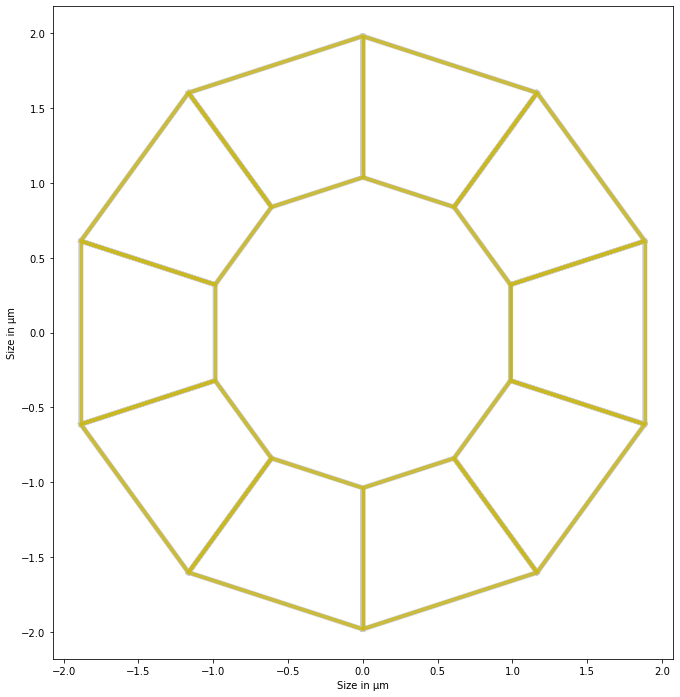

In [2]:
nf, r_in, r_out = (10, 1, 2)
seed = 1
organo = create_organo(nf, r_in, r_out)

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

Dans cet exemple on construit le point initial en perturbant les paramètres par une loi normale.

Remarque : soit $N_f$ le nombre de cellules du maillage, le vecteur des paramètres est composé de $3N_f$ tensions, $N_f$ aires d'équilibres et de l'aire du lumen. 

In [3]:
init_t = (organo.edge_df.line_tension.values + np.random.normal(0.0, 0.01, organo.Ne))[:3*organo.Nf]
init_a = organo.face_df.prefered_area.values + np.random.normal(0.0, 0.01, organo.Nf)
init_l = organo.settings['lumen_prefered_vol'] +  np.random.normal(0.0, 0.01, 1)

init_point = np.r_[init_t, init_a, init_l]

In [4]:
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-4, 'verbose': 0}

### Procédure de recalage

On dispose de tout les éléments nécéssaires pour lancer la procédure de recalage.

La procédure se lance avec la fonction adjust_parameters du module adjusters.adjust_annular. Cette fonction prend en paramètres :

- eptm: un maillage de class AnnularSheet
- initial_guess: un vecteur de valeurs initiales pour les paramètres d'optimisation
- main_min_opt: un dictionnaire précisant les options pour la procédure de recalage. Voir doc scipy.least_squares.

En plus, adjust_parameters a des paramètres optionnels qu'il n'est pas nécéssaires de préciser:

- parameters: defaut = [('edge', 'line_tension'), ('face', 'prefered_area')]
              une liste des paramètres à modifier dans le maillage
- energy_min_opt: defaut = None; Paramètres du L-BFGS-B pour la minimisation d'énergie. Si None, utilise les paramètres par défaut de tyssue.
- iprint_file: defaut = None; Chemin vers un fichier pour enregistrer les appels de la fonction objectif. Util car lm ne retourne pas d'information à chaque étape de la procédure d'optimisation. Si None, aucun fichier n'est écrit.
- COPY_OR_SYM: defaut = 'copy'. Détermine si l'organoïde expérimental est initialiser comme une copie de l'organoïde théorique ('copy') ou comme un organoïde régulier ('sym').

In [5]:
start = time.time()
res = adjust_parameters(organo, init_point, **lm_opt)
end = time.time() - start
print("Solving time = ", end,
      "   |   f(x*) = ", np.sum(res.fun))

Solving time =  255.0208113193512    |   f(x*) =  0.0
